In [1]:
import csv
import pandas as pd
import numpy as np
import math
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sn

Reading datasets
========
* warszawa_desc.csv: description of flats
* warszawa.txt: Information about flats. They will be used to define labels. 
* polish_stopwords.txt: Polish stopwords
* odm.txt: polish dictionary 

In [2]:
with open("data/warszawa_desc.csv") as f:
    reader = csv.reader(f, delimiter=';', quotechar='|')
    lst = []
    col_names = []
    for i,row in enumerate(reader):
        if i == 0:
            col_names = row
            continue
        lst.append(dict(zip(col_names,row)))
sample = pd.DataFrame(lst).set_index('Id')

print('Example descripition:\n\n',sample['Desc']['55582168'])

Example descripition:

  jasne i przestronne mieszkanie czeka na nowego właściciela. do dyspozycji 2 pokoje, oddzielna, widna kuchnia, łazienka, przedpokój, przestronny balkon, piwnica (10m2). nieruchomość w stanie deweloperskim. przygotowana dla nowych właścicieli i stwarzająca im możliwościowi własnej aranżacji wnętrza. mieszkanie znajduje się na 1 piętrze 3 piętrowego bloku z cegły z 1949 r. idealne jako inwestycja lub mieszkanie dla rodziny. 


In [3]:
with open("data/warszawa.csv") as f:
    reader = csv.reader(f, delimiter=';', quotechar='|')
    lst = []
    col_names = []
    for i,row in enumerate(reader):
        if i == 0:
            col_names = row
            continue
        lst.append(dict(zip(col_names,row)))
labels = pd.DataFrame(lst).set_index('Id')[['Borough','age_mean','price_per_sqm',
                                            'building_material','building_type']]
print('Example:\n\n',labels.loc[['55582168']])

Example:

           Borough age_mean price_per_sqm building_material building_type
Id                                                                      
55582168  mokotów     70.0        8750.0             brick         block


In [4]:
with open('utils/odm.txt',encoding='utf-8') as f:
    read = csv.reader(f, delimiter=',', quotechar='|')
    pl_dict = dict()
    for i,row in enumerate(read):
        if len(row) == 1:
            continue
        values = [row[0].lower()] * len(row)
        temp_dict = dict(zip([w.lstrip().lower() for w in row],values))
        pl_dict.update(temp_dict)

print('Example\nWord dane (data in english) in different declension forms is casted to one nominative form')
print('\t',pl_dict['dane'], pl_dict['danych'], pl_dict['daną'])

Example
Word dane (data in english) in different declension forms is casted to one nominative form
	 dany dany dany


In [5]:
with open('utils/polish_stopwords.txt') as f:
    read = csv.reader(f, delimiter=';', quotechar='|')
    stop_words = []
    for i,row in enumerate(read):
        stop_words.append(row[0])
        
print('Example stop words:\n',stop_words[0:200:20])

Example stop words:
 ['a', 'będę', 'cała', 'dobrze', 'gdzies', 'jakichś', 'jemu', 'ktorego', 'ma', 'mozna']


Other datasets
=======
* borough_names: names of borough (with declension forms), They will be removed from flats' description as they might influence our analysis

In [6]:
boroughs_name = ['bemowo','bemowa','bemowu','bemowem','bemowie',
                 'białołęka','białołęki','białołęce','białołękę','białołęką','białołęko',
                 'bielany','bielan','bielanom','bielany','bielanami','bielanach',
                 'mokotów','mokotowa','mokotowowi','mokotowem','mokotowie',
                 'ochota','ochoty','ochotę','ochotą','ochocie','ochoto',
                 'praga','pragi','pradze','pragą','pradze','prago',
                 'rembertów','rembertowa','rembertowowi','rembertów','rembertowem','rembertowie','rembertowie',
                 'śródmieście','śródmieścia','śródmieściu','śródmieściem',
                 'targówek','targówka','targówkowi','targówkiem','targówku',
                 'ursus','ursusa','ursusowi','ursusa','ursusem','ursusie',
                 'ursynów','ursynowa','ursynowowi','ursynów','ursynowem','ursynowie',
                 'wawer','wawra','wawrowi','wawrem','wawrze',
                 'wesoła','wesołą','wesołej',
                 'wilanów','wilanowa','wilanowowi','wilanowem','wilanowie',
                 'włochy','włochów','włochom','włochami','włochach',
                 'wola', 'woli', 'woli', 'wolę', 'wolą', 'woli', 'wolo',
                 'żoliborz','żoliborza','żoliborzowi','żoliborz','żoliborzem','żoliborzu']

Cleaning descriptions
===========
Description are changed in following steps:
* replacing chars: numbers and punctuation symbols with single whitespace character
* replacing double whitespace character with single whitespace characters
* removing stopwords
* removing single character word
* removing borough names
* changing declined words to their basic form

In [7]:
txt = []
for desc in sample['Desc']:
    desc = re.sub('[0123456789,.()$%:*;|!?-_]', ' ', desc)
    desc.replace('  ',' ')
    lst = [w for w in desc.split() if w not in stop_words]
    lst = [w for w in lst if len(w) > 1]
    lst = [w for w in lst if w not in boroughs_name]
    final_lst = []
    for w in lst:
        if w in pl_dict:
            final_lst.append(pl_dict[w])
        else:
            final_lst.append(w)  
    txt.append(' '.join(final_lst))    
sample['txt'] = txt 

del pl_dict, stop_words
del lst, final_lst, txt

print('Original descripition:\n\n',sample['Desc']['55582168'],'\n\n')
print('Modified descripition:\n\n',sample['txt']['55582168'])

Original descripition:

  jasne i przestronne mieszkanie czeka na nowego właściciela. do dyspozycji 2 pokoje, oddzielna, widna kuchnia, łazienka, przedpokój, przestronny balkon, piwnica (10m2). nieruchomość w stanie deweloperskim. przygotowana dla nowych właścicieli i stwarzająca im możliwościowi własnej aranżacji wnętrza. mieszkanie znajduje się na 1 piętrze 3 piętrowego bloku z cegły z 1949 r. idealne jako inwestycja lub mieszkanie dla rodziny.  


Modified descripition:

 jasny przestronny mieszkanie czeka nowy właściciel dyspozycja pokój oddzielny widny kuchnia łazienka przedpokój przestronny balkon piwnica nieruchomość stan deweloperski przygotowany nowy właściciel stwarzać możliwościowy własny aranżacja wnętrze mieszkanie znajdywać piętro piętrowy blok cegła idealny inwestycja mieszkanie rodzina


Creating labels
========

We create few labels marking:
* age
* price
* building type and material



**Age_cat**

* 2000-: 2000s
* 1990-1999: 90s
* 1980-1989: 80s
* 1960-1979: communist
* 1945-1959: afterwar
* ... -1944: beforewar

In [8]:
def age_cat_create(x):
    if float(x) <= 18.0:
        return '2000s'
    elif float(x) <= 28.0:
        return '90s'
    elif float(x) <= 38.0:
        return '80s'
    elif float(x) <= 58.0:
        return 'communist'
    elif float(x) <= 73.0:
        return 'afterwar'
    return 'beforewar'
labels['age_cat'] = labels['age_mean'].apply(age_cat_create)

**Price_cat1**

* 1st quintile calculated for whole sample, labelled: *low*
* 2nd quintile calculated for whole sample, labelled: *midlow*
* 3rd quintile calculated for whole sample, labelled: *mid*
* 4th quintile calculated for whole sample, labelled: *midhigh*
* 5th quintile calculated for whole sample, labelled: *high*

In [9]:
labels['price_per_sqm'] = labels['price_per_sqm'].apply(pd.to_numeric)
def price_cat1_create(q20,q40,q60,q80):
    def f(x):
        if x < q20:
            return 'low'
        elif x < q40:
            return 'midlow'
        elif x < q60:
            return 'mid'
        elif x < q80:
            return 'midhigh'
        else:
            return 'high'  
    return f     
labelling_price_cat1 = price_cat1_create(labels['price_per_sqm'].quantile(q=0.2),
                                         labels['price_per_sqm'].quantile(q=0.4),
                                         labels['price_per_sqm'].quantile(q=0.6),
                                         labels['price_per_sqm'].quantile(q=0.8),) 
labels['price_cat1'] = labels['price_per_sqm'].apply(labelling_price_cat1)  

**Price_cat2**

* 1st quintile calculated for each borough, labelled: *low*
* 2nd quintile calculated for each borough, labelled: *midlow*
* 3rd quintile calculated for each borough, labelled: *mid*
* 4th quintile calculated for each borough, labelled: *midhigh*
* 5th quintile calculated for each borough, labelled: *high*

In [10]:
q20_for_borough = dict()
q40_for_borough = dict()
q60_for_borough = dict()
q80_for_borough = dict()

for item in labels['Borough'].unique():
    q20_for_borough[item] = labels[labels['Borough']==item]['price_per_sqm'].quantile(q=0.2)
    q40_for_borough[item] = labels[labels['Borough']==item]['price_per_sqm'].quantile(q=0.4)
    q60_for_borough[item] = labels[labels['Borough']==item]['price_per_sqm'].quantile(q=0.6)
    q80_for_borough[item] = labels[labels['Borough']==item]['price_per_sqm'].quantile(q=0.8)

def price_cat1_create(q20,q40,q60,q80):
    def f(x):
        if x['price_per_sqm'] < q20[x['Borough']]:
            return 'low'
        elif x['price_per_sqm'] < q40[x['Borough']]:
            return 'midlow'
        elif x['price_per_sqm'] < q60[x['Borough']]:
            return 'mid'
        elif x['price_per_sqm'] < q80[x['Borough']]:
            return 'midhigh'
        else:
            return 'high'  
    return f 
labelling_price_cat2 = price_cat1_create(q20_for_borough,q40_for_borough,q60_for_borough,q80_for_borough) 
labels['price_cat2'] = labels.apply(labelling_price_cat2,axis=1) 

**Merging description sample and labels**

In [11]:
sample = pd.merge(sample, labels, right_index=True, left_index=True)

Term frequency–inverse document frequency
=====================

We perform analysis of flats' description using *Bag of words* model. We create the vector of words contained by descriptions and transform them using TFIDF technique.

Settings
* sublinear_df is set to True to use a logarithmic form for frequency.
* min_df is the minimum numbers of documents a word must be present in to be kept. We will set this parameter to 4 and 10 to check the sensitivity of our analysis to that parameter
* norm is set to l2, to ensure all our feature vectors have a euclidian norm of 1.
* ngram_range is set to (1, 2) to indicate that we want to consider both unigrams and bigrams.

In [12]:
tfidf4 = TfidfVectorizer(sublinear_tf=True, min_df=4, norm='l2', encoding='utf-8',ngram_range=(1,2))
features_4df = tfidf4.fit_transform(sample['txt']).toarray()
print('Bag of words for df = 4 counts ',features_4df.shape[1],' observations (uni and bigrams)')

tfidf10 = TfidfVectorizer(sublinear_tf=True, min_df=10, norm='l2', encoding='utf-8',ngram_range=(1,2))
features_10df = tfidf10.fit_transform(sample['txt']).toarray()
print('Bag of words for df = 10 counts ',features_10df.shape[1],' observations (uni and bigrams)')

Bag of words for df = 4 counts  48469  observations (uni and bigrams)
Bag of words for df = 10 counts  21528  observations (uni and bigrams)


In [13]:
def perform_text_analysis(df,n,label,tfidf,features):
    cols = list(range(1,n+1))
    test = df[['txt',label]].copy()
    test['category'] = test[label].factorize()[0]
    category_to_id  = test[[label, 'category']].drop_duplicates().sort_values('category').set_index(label).to_dict()['category']

    results = pd.DataFrame()
    for item, category_id in sorted(category_to_id.items()):
        features_chi2 = chi2(features, test.category == category_id)
        indices = np.argsort(features_chi2[0])
        feature_names = np.array(tfidf.get_feature_names())[indices]
        
        unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
        bigrams  = [v for v in feature_names if len(v.split(' ')) == 2]
        trigrams = [v for v in feature_names if len(v.split(' ')) == 3]

        if len(unigrams) > 0:
            dct = dict(zip(cols,unigrams[-n:]))
            dct['Category'] = item
            dct['Terms'] = 'unigram'
            results = results.append(dct,ignore_index=True)
        
        if len(bigrams) > 0:            
            dct = dict(zip(cols,bigrams[-n:]))
            dct['Category'] = item
            dct['Terms'] = 'bigram'
            results = results.append(dct,ignore_index=True)
        
        if len(trigrams) > 0:            
            dct = dict(zip(cols,unigrams[-n:]))
            dct['Category'] = item
            dct['Terms'] = 'trigram'
            results = results.append(dct,ignore_index=True)
    del test
    return results

**Analysis of age**

We analyze what words are used to describe apartments that differ by age. We also check if using different threshold for uni- and bigrams frequency has large impact on results of analysis.

In descipription of old flats (builded before WW2) it is emphesised that flat is located in *before war tenement house*. Also among most frequent term we can find:
* *keep original*,
* *vintage*,
* *original parquet*,
* *original woodwork*,
* *restored tenement house*,
* *masonry (stove)*

In modern flats (2000- ) we can find: *underground garage*, *the basement is included*, *total makeover* and *kitchen with window*.


We can clearly see that Warsaw's boroughs were build in different periods as we see words related to location of flat:
* before and just after the war: Ogród Krasińskich
* 60's and 70's Żoliborz and Praga
* 80's and 90's : Natolin and Ursynów


In [14]:
age_cat = perform_text_analysis(sample, 12, 'age_cat',tfidf4,features_4df)
age_cat.head(60)

,1,2,3,4,5,6,7,8,9,10,11,12,Category,Terms
0,uregulować,pion,wymian,pcc,klatka,generalny,inwestycja,instalacja,kamienica,wymienić,piwnica,remont,2000s,unigram
1,widny kuchnia,bez prowizja,bez podatek,instalacja elektryczny,spółdzielczy własnościowy,garaż podziemny,wodno kanalizacyjny,podatek pcc,klatka schodowy,wymienić instalacja,generalny remont,przynależeć piwnica,2000s,bigram
2,okulicki,blok,gocław,uregulować,ocieplić,karton,spółdzielczy,buda,profit,nieruchomościkonrad,frejlich,natolin,80s,unigram
3,mina rower,natolin minuta,gips gładź,blok powstać,gładź wymienić,mieścić rower,nieruchomościkonrad frejlich,dębowy szary,natolin ulica,kanalizacyjny wyremontować,frejlich pokazać,metr natolin,80s,bigram
4,relaksowy,dwupoziomowy,lex,książkowy,zalecać,poziom,kosmowski,inwestycja,zakroczymski,kabacki,bohaterewicza,kabat,90s,unigram
5,las kabacki,ul bohaterewicza,kosmowski tel,marta kosmowski,metr kabat,kabat mina,informacyjny zalecać,zalecać weryfikacja,propozycja stan,liczyć podłoga,niniejsza propozycja,dwupoziomowy mieszkanie,90s,bigram
6,podwórko,wymienić,instalacja,piwnica,pięćdziesiąty,remont,muranów,tych,krasiński,arsenał,cegła,kamienica,afterwar,unigram
7,przynależeć piwnica,piętrowej kamienica,cegła nowy,czynsz własność,pokój zrobić,kamienica tych,kamienica cegła,budynek cegła,piętrowy kamienica,piętro kamienica,ogród krasiński,ratusz arsenał,afterwar,bigram
8,ujazdowski,kancelaria,filtrowy,klimatyczny,podwórze,kaflowy,zabytkowy,zachować,oryginalny,odrestaurować,przedwojenny,kamienica,beforewar,unigram
9,piec kaflowy,oryginalny stolarka,odrestaurować kamienica,mieszkanie kamienica,oryginalny parkiet,kamienica mieszkanie,budynek kamienica,zachować oryginalny,piętro przedwojenny,zabytkowy kamienica,mieszkanie przedwojenny,przedwojenny kamienica,beforewar,bigram


In [15]:
age_cat = perform_text_analysis(sample, 12, 'age_cat',tfidf10,features_10df)
age_cat.head(60)

,1,2,3,4,5,6,7,8,9,10,11,12,Category,Terms
0,uregulować,pion,wymian,pcc,klatka,generalny,inwestycja,instalacja,kamienica,wymienić,piwnica,remont,2000s,unigram
1,bez prowizja,bez podatek,widny kuchnia,instalacja elektryczny,spółdzielczy własnościowy,wodno kanalizacyjny,garaż podziemny,podatek pcc,klatka schodowy,wymienić instalacja,generalny remont,przynależeć piwnica,2000s,bigram
2,piwnica,stokłosa,gocław,gips,blok,uregulować,ocieplić,karton,spółdzielczy,nieruchomościkonrad,frejlich,natolin,80s,unigram
3,natolin mieszkanie,doskonały rozplanować,okno kaloryfer,plastikowy ekspozycja,duży winda,wola park,ocieplić klatka,spółdzielczy własnościowy,karton gips,nieruchomościkonrad frejlich,frejlich pokazać,metr natolin,80s,bigram
4,weryfikacja,pcc,oligoceński,kamienica,niniejsza,schód,dwupoziomowy,inwestycja,zalecać,poziom,kabacki,kabat,90s,unigram
5,pierwszy poziom,dolny poziom,sprzedaż pokój,poziom salon,las kabacki,metr kabat,informacyjny zalecać,zalecać weryfikacja,propozycja stan,liczyć podłoga,niniejsza propozycja,dwupoziomowy mieszkanie,90s,bigram
6,podwórko,wymienić,instalacja,piwnica,pięćdziesiąty,remont,muranów,tych,krasiński,arsenał,cegła,kamienica,afterwar,unigram
7,przynależeć piwnica,metr racławicki,piętrowej kamienica,metro ratusz,czynsz własność,kamienica tych,kamienica cegła,budynek cegła,piętrowy kamienica,piętro kamienica,ogród krasiński,ratusz arsenał,afterwar,bigram
8,sejm,kancelaria,ujazdowski,klimatyczny,kaflowy,podwórze,zabytkowy,zachować,oryginalny,odrestaurować,przedwojenny,kamienica,beforewar,unigram
9,kamienica remont,oryginalny stolarka,mieszkanie kamienica,odrestaurować kamienica,oryginalny parkiet,kamienica mieszkanie,budynek kamienica,zachować oryginalny,piętro przedwojenny,zabytkowy kamienica,mieszkanie przedwojenny,przedwojenny kamienica,beforewar,bigram


**Analysis of prizes**

We observe that most expensive flats are described by: *luxuary apartment*, *apartment*. Those apartments are also located near most prestigious streets: Krakowskie Przedmieście, Nowy Świat, Bulwary Wiślane 
Also some descirptions of most expensive flats are written in english.

The cheapest flats (low and midlow) are located in east-north districts (*Ząbki*,*Tarchomin*,*Żerań*), probably far from the city center that is why the good comunication is emphesised (*direct bus*, *SKM train stop*), sport facilites (*active live*, *recreation*). 

If we look at relatively expensive flats (most expensive in given borough), we observe that it is emphasised that flat is *finished to a high standard* and close to *green parks*.

In [16]:
price_cat1 = perform_text_analysis(sample, 12, 'price_cat1',tfidf4,features_4df)
price_cat1.head(60)

,1,2,3,4,5,6,7,8,9,10,11,12,Category,Terms
0,recepcja,apartment,is,odrestaurować,of,anda,luksusowy,prestiżowy,the,powiśle,kamienica,apartament,high,unigram
1,zaledwie apartament,in the,nauka kopernik,luksusowy apartament,malowniczy park,apartament przynależeć,centrum nauka,bulwar wiślany,apartament wykończyć,of the,krakowski przedmieście,nowy świat,high,bigram
2,derby,nisko,osiedle,kanał,urs,ząbki,marywilska,płochocińska,żerań,tarchomin,marymont,żerański,low,unigram
3,przystanek skm,posiadać układ,metr marymont,galeria północny,dostępny różny,usługowy okolica,kameralny zabudowa,metro marymont,marywilska osiedle,most północny,bezpośredni autobus,kanał żerański,low,bigram
4,imieniny,przemiana,zaściankowy,szwedzka,zoo,bezpieczniejszy,cienić,mieście,wzorzec,najpotrzebniejszy,szwedzki,środkowy,mid,unigram
5,szwedzki stacja,ruch samochód,rowerowy ulica,wzorzec zmiana,środkowy stać,ruch lokalny,zmiana cały,środkowy ruch,czas ulica,samochód ograniczyć,metr szwedzki,ulica środkowy,mid,bigram
6,karolkowy,cmentarz,krajobraz,łuków,kilkurodzinny,wilanowski,bartoszek,bukowiński,wałbrzyska,wosir,podbipięta,dominikański,midhigh,unigram
7,kameralność inwestycja,in staw,wosir siłownia,staw dobry,królikarnia wosir,daleki królikarnia,apteka daleki,dwupiętrowy zabudowa,chronić krajobraz,podbipięta autobus,dominikański autobus,najbliższy stacja,midhigh,bigram
8,wytchnienie,sześć,mór,sznajdra,wszechstronny,cooper,corpores,glinianka,górczewska,chrzan,garden,larix,midlow,unigram
9,rejon fort,komunikacyjny rekreacja,kondygnacja lokal,myśl potrzeby,usługi bliski,estetyczny osiedle,pomiędzy aktywny,miasto dzielnica,pokojowe metraż,rekreacyjny in,park górczewska,larix garden,midlow,bigram


In [17]:
price_cat1 = perform_text_analysis(sample, 12, 'price_cat1',tfidf10,features_10df)
price_cat1.head(60)

,1,2,3,4,5,6,7,8,9,10,11,12,Category,Terms
0,recepcja,apartment,is,odrestaurować,of,anda,luksusowy,prestiżowy,the,powiśle,kamienica,apartament,high,unigram
1,malowniczy park,the apartment,nauka kopernik,in the,luksusowy apartament,centrum nauka,apartament przynależeć,bulwar wiślany,apartament wykończyć,krakowski przedmieście,of the,nowy świat,high,bigram
2,zdziarski,urs,nisko,marywilska,kanał,osiedle,płochocińska,ząbki,żerań,tarchomin,marymont,żerański,low,unigram
3,zielony dolina,postojowy naziemny,tras most,dostępny różny,galeria północny,metr marymont,kameralny zabudowa,marywilska osiedle,metro marymont,bezpośredni autobus,most północny,kanał żerański,low,bigram
4,praskiego,apartament,mieście,bezpieczniejszy,cienić,zoo,zaściankowy,wzorzec,szwedzka,najpotrzebniejszy,szwedzki,środkowy,mid,unigram
5,ruch samochód,wzorzec zmiana,rowerowy ulica,środkowy stać,przedszkole odległość,ruch lokalny,zmiana cały,środkowy ruch,samochód ograniczyć,czas ulica,metr szwedzki,ulica środkowy,mid,bigram
6,obrzeżny,łuków,krajobraz,karolkowy,kilkurodzinny,bartoszek,wilanowski,wałbrzyska,bukowiński,wosir,podbipięta,dominikański,midhigh,unigram
7,kameralność inwestycja,wosir siłownia,in staw,królikarnia wosir,staw dobry,daleki królikarnia,dwupiętrowy zabudowa,apteka daleki,podbipięta autobus,chronić krajobraz,dominikański autobus,najbliższy stacja,midhigh,bigram
8,wytchnienie,sześć,mór,sznajdra,wszechstronny,cooper,corpores,glinianka,górczewska,chrzan,garden,larix,midlow,unigram
9,zachowanie harmonia,aktywny żyć,myśl potrzeby,kondygnacja lokal,usługi bliski,estetyczny osiedle,pomiędzy aktywny,miasto dzielnica,rekreacyjny in,pokojowe metraż,park górczewska,larix garden,midlow,bigram


In [18]:
price_cat2 = perform_text_analysis(sample, 12, 'price_cat2',tfidf4,features_4df)
price_cat2.head(60)

,1,2,3,4,5,6,7,8,9,10,11,12,Category,Terms
0,golden,radium,eko,with,anda,apartment,is,penthouse,of,the,luksusowy,apartament,high,unigram
1,powstanie cześć,prywatny zielony,zapewniać idealny,wierzbno tramwaj,polski radium,eko park,park prezentować,zaledwie apartament,of the,luksusowy apartament,malowniczy park,apartament wykończyć,high,bigram
2,przetarg,ząbki,dwupoziomowy,rekreayjno,wypoczynkowe,łopuszański,apartament,wsród,optymistyczny,hadlowo,bruzdowy,skrzatki,low,unigram
3,zielony każdy,pakiet smart,osiedlowy duży,ul sowiński,strefa zielony,bogaty strefa,anna skrzatki,przychodzień mniejszy,spotkanie anna,skrzatki pokazać,ekspozycja etap,sowiński warszawa,low,bigram
4,wytchnienie,cooper,sznajdra,mór,glinianka,corpores,podbipięta,dominikański,wszechstronny,chrzan,garden,larix,mid,unigram
5,stolica pozwalać,pozwalać zachowanie,najnowszy warszawski,stacja mór,dzielnica wyjątkowy,komfort przyszły,podbipięta autobus,ostatni stacja,dominikański autobus,rekreacyjny in,istotny atut,larix garden,mid,bigram
6,zbiornik,odpoczynkowy,residences,gęsty,sprzety,zamieszkały,pięcio,hygge,sushi,kaucja,zakroczymski,luxor,midhigh,unigram
7,kamienica cichy,początek inwestycja,panoramiczny drewniany,zachęcać żyć,veturilo zachęcać,powietrze ścieżka,informacja zapraszać,budynek jasny,wokół sprzyjać,prysznic budynek,balkon dzielnica,handlowy rekreacyjny,midhigh,bigram
8,jack,wiatraczny,łukowski,burza,derby,multipleks,garażu,czapelski,gdecka,morelowy,urs,apartament,midlow,unigram
9,autobus łukowski,południe bezpośredni,szembek tramwaj,miłośnik aktywny,wiatraczny daleki,wspólny drogi,pl szembek,dwa plac,maksymalny doświetlić,październik listopad,doświetlić pokój,ulica wiatraczny,midlow,bigram


In [19]:
price_cat2 = perform_text_analysis(sample, 12, 'price_cat2',tfidf10,features_10df)
price_cat2.head(60)

,1,2,3,4,5,6,7,8,9,10,11,12,Category,Terms
0,master,radium,eko,with,anda,apartment,is,penthouse,of,the,luksusowy,apartament,high,unigram
1,wykończyć wysoki,prywatny zielony,zapewniać idealny,wierzbno tramwaj,polski radium,eko park,park prezentować,zaledwie apartament,malowniczy park,of the,luksusowy apartament,apartament wykończyć,high,bigram
2,rekreayjno,wypoczynkowe,łopuszański,dwupoziomowy,przetarg,ząbki,wsród,hadlowo,optymistyczny,apartament,bruzdowy,skrzatki,low,unigram
3,mniejszy sklep,zielony każdy,pakiet smart,dwupoziomowy mieszkanie,osiedlowy duży,strefa zielony,przychodzień mniejszy,anna skrzatki,spotkanie anna,skrzatki pokazać,bogaty strefa,ekspozycja etap,low,bigram
4,wytchnienie,cooper,sznajdra,mór,corpores,glinianka,podbipięta,dominikański,wszechstronny,chrzan,garden,larix,mid,unigram
5,wytchnienie przyroda,budynek sześć,szkoła gabinet,natura planować,dzielnica wyjątkowy,podbipięta autobus,komfort przyszły,rekreacyjny in,dominikański autobus,ostatni stacja,istotny atut,larix garden,mid,bigram
6,bobrowieckiej,dwukondygnacyjny,piekarnik,nieliczni,marina,odpoczynkowy,ostrogski,zasiewskamjp,zbiornik,gęsty,zamieszkały,sushi,midhigh,unigram
7,sprzyjać odpoczynkowy,apartament serce,jednoczesny doskonały,stacja veturilo,remont wykończyć,park laski,dwukondygnacyjny garaż,restauracja knajpka,autobus sklep,środki zakup,informacja zapraszać,panoramiczny drewniany,midhigh,bigram
8,zdziarski,zawadowski,derby,multipleks,zaściankowy,czapelski,burza,garażu,gdecka,morelowy,urs,apartament,midlow,unigram
9,autobus łukowski,miejski gdecka,gdecka autobus,miłośnik aktywny,wiatraczny daleki,wspólny drogi,pl szembek,skomunikować miasto,maksymalny doświetlić,dwa plac,doświetlić pokój,ulica wiatraczny,midlow,bigram


**Analysis of boroughs**

In [20]:
boroughs = perform_text_analysis(sample, 12, 'Borough',tfidf4,features_4df)
boroughs.head(60)

,1,2,3,4,5,6,7,8,9,10,11,12,Category,Terms
0,wszechstronny,bem,sześć,glinianka,corpores,sznajdra,cooper,fort,garden,chrzan,larix,górczewska,bemowo,unigram
1,położyć zachodni,corpores sp,garden stan,powierzchnia zapewniać,zlokalizować rejon,metr chrzan,stacja ii,fort chrzan,osiedle cooper,rekreacyjny in,larix garden,park górczewska,bemowo,bigram
2,zdziarski,młociny,żerań,kanał,klasyk,białołęka,marywilska,henrykowski,żerański,marymont,nowodwory,tarchomin,białołęka,unigram
3,ramy inwestycja,nowodwory mieszkanie,dostępny różny,metr młociny,zielony dolina,ulica klasyk,metr marymont,marywilska osiedle,kanał żerański,park henrykowski,most północny,galeria północny,białołęka,bigram
4,keller,uksw,broniewski,herbert,potocki,młociński,młociny,chomiczówka,awf,słodowiec,wawrzyszew,bielański,bielany,unigram
5,marymont żeromski,ul marymoncki,staw keller,keller park,słodowiec stacja,park kaskada,kępa potocki,laski bielański,metr starzy,metr wawrzyszew,metr słodowiec,las bielański,bielany,bigram
6,best,wilanowski,cybernetyk,mall,morski,służewiec,stegny,służew,racławicki,sadyba,królikarnia,wierzbno,mokotów,unigram
7,park sielecki,wilanowski stacja,park morski,jeziorko czerniakowski,metr wilanowski,metr służew,sadyba best,metr racławicki,łazienki królewski,best mall,morski oko,metr wierzbno,mokotów,bigram
8,ochota,włodarzewskiej,szczęśliwice,łopuszański,narutowicz,skrzatki,reduta,wkd,banach,grójecki,blue,szczęśliwicki,ochota,unigram
9,osiedlowy duży,city ch,bogaty strefa,anna skrzatki,przychodzień mniejszy,skrzatki pokazać,spotkanie anna,strefa zielony,ch reduta,ch blue,blue city,park szczęśliwicki,ochota,bigram


In [21]:
boroughs = perform_text_analysis(sample, 12, 'Borough',tfidf10,features_10df)
boroughs.head(60)

,1,2,3,4,5,6,7,8,9,10,11,12,Category,Terms
0,wszechstronny,lazurowy,corpores,glinianka,sznajdra,bem,cooper,fort,garden,chrzan,larix,górczewska,bemowo,unigram
1,firma corpores,powierzchnia zapewniać,zlokalizować rejon,planować stacja,metr chrzan,stacja ii,fort chrzan,fort bem,osiedle cooper,rekreacyjny in,larix garden,park górczewska,bemowo,bigram
2,zdziarski,młociny,kanał,żerań,klasyk,marywilska,białołęka,henrykowski,żerański,marymont,nowodwory,tarchomin,białołęka,unigram
3,pośredniktarchomin pośrednikbiałołęka,nowodwory mieszkanie,dostępny różny,ulica klasyk,metr młociny,zielony dolina,marywilska osiedle,metr marymont,kanał żerański,park henrykowski,most północny,galeria północny,białołęka,bigram
4,keller,uksw,broniewski,herbert,potocki,młociński,młociny,chomiczówka,awf,słodowiec,wawrzyszew,bielański,bielany,unigram
5,podczaszyński autobus,marymont żeromski,słodowiec stacja,staw keller,keller park,park kaskada,kępa potocki,laski bielański,metr starzy,metr wawrzyszew,metr słodowiec,las bielański,bielany,bigram
6,wilanowski,best,cybernetyk,mall,służewiec,stegny,morski,służew,racławicki,sadyba,królikarnia,wierzbno,mokotów,unigram
7,park arkadia,park sielecki,metr wilanowski,park morski,jeziorko czerniakowski,metr służew,metr racławicki,sadyba best,łazienki królewski,best mall,morski oko,metr wierzbno,mokotów,bigram
8,szczęśliwice,białobrzeski,włodarzewskiej,łopuszański,narutowicz,skrzatki,wkd,reduta,banach,blue,grójecki,szczęśliwicki,ochota,unigram
9,osiedlowy duży,spotkanie anna,anna skrzatki,bogaty strefa,skrzatki pokazać,przychodzień mniejszy,city ch,strefa zielony,ch reduta,ch blue,blue city,park szczęśliwicki,ochota,bigram


Analysis of building materials
----------------------

In [22]:
materials = perform_text_analysis(sample, 12, 'building_material',tfidf4,features_4df)
materials.head(60)

,1,2,3,4,5,6,7,8,9,10,11,12,Category,Terms
0,haven,przyciągać,coraz,mieszkańców,balkonami,tarasami,ogródkami,standardem,szwecki,inwestorów,doskonałą,funkcjonalnymi,aerated_concrete,unigram
1,szwecki powstanie,funkcjonalnymi rozkład,mieszkańców pobliże,koniec galeria,stały rozwijać,lokalizacja balkonami,inwestorów mieszkańców,rozwijać przyciągać,powstanie koniec,wyróżniać standardem,gastronomiczny inwestycja,coraz zainteresowany,aerated_concrete,bigram
2,równy,walor,dynamiczny,wytchnienie,mór,sznajdra,wszechstronny,corpores,glinianka,chrzan,garden,larix,breezeblock,unigram
3,pozwalać zachowanie,mór różnorodny,wytchnienie przyroda,standard wygoda,garden stan,garden osiedle,garden najnowszy,miejski dawać,wszechstronny wybór,cztery kondygnacja,inwestycja firma,larix garden,breezeblock,bigram
4,podatek,pcc,autobus,formularz,ciąg,przedwojenny,dalszy,metraż,kwartał,inwestycja,cegła,kamienica,brick,unigram
5,kontakt zapraszać,budynek cegła,prowizja dalszy,bez prowizja,formularz treść,numer formularz,dalszy ciąg,ciąg dostępny,zakup bez,pcc bez,cegła ciepły,materiał cegła,brick,bigram
6,tresa,whirpool,najszybciej,viii,prezentację,rezerwować,siedemset,sześćset,pięćset,szafkowy,bakalarski,dwadzieścia,concrete,unigram
7,zainwestować kapitał,pierwotny stan,szybki przedostać,przedostać każdy,uwaga zapraszać,rewitalizacja kamienica,zabudowa szafkowy,najszybciej sprzedawać,rentowność netto,skm kolej,państwo atrakcyjny,pokojowy warszawski,concrete,bigram
8,generalny,wymienić,sitocity,nieruchomościlicencja,żaneta,piwnica,gotówka,spółdzielczy,uregulować,profit,blok,remont,concrete_plate,unigram
9,kino szkoła,nieruchomościlicencja numer,numer żaneta,profit nieruchomościlicencja,żaneta sitocity,sitocity profit,spółdzielczy własnościowy,przynależeć piwnica,blok wielki,płyta ciepły,materiał płyta,wielki płyta,concrete_plate,bigram


Analysis of building types
----------------------

In [23]:
building_type = perform_text_analysis(sample, 12, 'building_type',tfidf4,features_4df)
building_type.head(60)

,1,2,3,4,5,6,7,8,9,10,11,12,Category,Terms
0,inwestycja,hol,prezentować,piwnica,ulokować,remont,apartamentowiec,ciąg,autobus,dalszy,formularz,apartament,apartment,unigram
1,inwestycja zapraszać,metraż inwestycja,kontakt zapraszać,pcc bez,zakup bez,dostępny rozkład,rozkład metraż,ciąg dostępny,dalszy ciąg,prowizja dalszy,formularz treść,numer formularz,apartment,bigram
2,chrzan,inwestycja,garden,prestiżowy,apartamentowiec,autobus,larix,formularz,dalszy,kamienica,blok,apartament,block,unigram
3,larix garden,dostępny rozkład,kwartał zakup,kontakt zapraszać,rozkład metraż,prowizja dalszy,numer formularz,formularz treść,dalszy ciąg,ciąg dostępny,zakup bez,pcc bez,block,bigram
4,poddasze,dąbrówka,urzędów,rozmieścić,lewy,bezczynszowe,szlachecki,buk,poziomowy,bliźniaczy,kostkowie,brukowy,house,unigram
5,użytek idealny,zielony fitness,poziom łazienka,poziom każdy,mieszkanie poziomowy,fitness skm,klucz oddany,poziomowy doskonały,rodzina rozmieścić,rozmieścić poziom,kilka dom,dom cichy,house,bigram
6,kaufland,kilkaset,stawać,stalowy,spiżarnia,lokator,przedsionek,kontaktować,końcowy,pośród,zmieniać,posadowić,infill,unigram
7,hałas ulica,położyć nieruchomość,rok dynamiczny,sprzęt pralka,dziedziniec osiedle,wc posiadać,spiżarnia łazienki,mieszkalny jedyny,odległość metro,przeszklić salon,postojowy lokal,główny wc,infill,bigram
8,nowoczesność,jacuzzi,żelazny,sala,masaż,squash,such,niewielu,klubowy,gimnastyczny,mokry,szatnia,loft,unigram
9,warszawa budynek,prestiżowy inwestycja,komfort nowoczesność,ulica grzybowski,swój mieszkaniec,inwestycja charakteryzować,gra koszykówka,siłownia sala,warszawa centrum,sala klubowy,taras sala,mieścić in,loft,bigram


In [24]:
del features_4df
del features_10df

Classification
========

**Preparing validation sample**

We devide sample into three subsamples:
* Trainging sample (70%) that will be used to estimated logistic regression parameters
* Validation sample (20%) that will be used to find optimal value of hyperparameters (type of regularization and regularization term value)
* Test sample (10%) that will be used to test performance of final model

In [25]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=4, norm='l2', encoding='utf-8',ngram_range=(1,1))
features = tfidf.fit_transform(sample['txt']).toarray()
labels = np.array(sample['Borough'])
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.30, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_test, y_test, test_size=0.333, random_state=42) 

print('Training sample',X_train.shape[0],100*round(X_train.shape[0]/features.shape[0],3),'%')
print('Validation sample',X_validation.shape[0],100*round(X_validation.shape[0]/features.shape[0],3),'%')
print('Test sample',X_test.shape[0],100*round(X_test.shape[0]/features.shape[0],3),'%')

Training sample 5500 70.0 %
Validation sample 1572 20.0 %
Test sample 786 10.0 %


**Tuning hyperparameters**

Text data are characterized with large number of features. To not overfit the model we used parametric model: *logistic regression model* with regularization. We check what regularization type and regularization term  should be choose to avoid overfitting. 

We plotted the *accuracy ratio* as a function of regularization term value. We see that for **C > 2** we do not observe increase of accuracy ratio for validation sample. For **C > 10** we observe little decline of predictive power. We can conclude that **C = 2** is best choice for our model. 

L1 regularization outperforms L2 regularization. L1 is more robust to overfitting. L1 regularization is not fitted to train observations as L2, but performs better for validation sample.

We do not observe larger influence of TFIDF parameters on predictive power.

In [26]:
train_sample_score_l1 = []
test_sample_score_l1  = []

train_sample_score_l2 = []
test_sample_score_l2  = []

param = list(np.linspace(0.1,1.0,10)) + list(np.linspace(2,10,9))  + list(np.linspace(20,100,9)) 
for c in param:
    clf_l1 = LogisticRegression(random_state=0, multi_class='ovr',penalty='l1', C=c)
    model = clf_l1.fit(X_train, y_train)
    train_sample_score_l1.append(model.score(X_train, y_train))
    test_sample_score_l1.append(model.score(X_validation, y_validation))

    clf_l2 = LogisticRegression(random_state=0, multi_class='ovr',penalty='l2', C=c)
    model = clf_l2.fit(X_train, y_train)
    train_sample_score_l2.append(model.score(X_train, y_train))
    test_sample_score_l2.append(model.score(X_validation, y_validation))

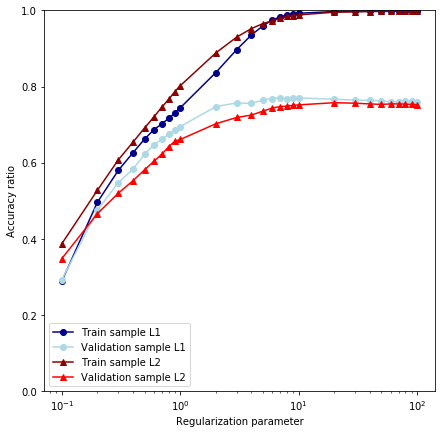

In [27]:
fig = plt.figure(figsize=(7,7))
plt.semilogx(param,train_sample_score_l1,'o-',c='darkblue' ,label='Train sample L1')
plt.semilogx(param,test_sample_score_l1 ,'o-',c='lightblue',label='Validation sample L1')
plt.semilogx(param,train_sample_score_l2,'^-',c='darkred'  ,label='Train sample L2')
plt.semilogx(param,test_sample_score_l2 ,'^-',c='red'      ,label='Validation sample L2')
plt.xlabel("Regularization parameter")
plt.ylabel("Accuracy ratio")
plt.ylim((0.0,1.0))
plt.legend()
plt.show()

In [28]:
train_sample_score_l1 = []
test_sample_score_l1  = []

train_sample_score_l2 = []
test_sample_score_l2  = []

for df in range(3,11):
    tfidf = TfidfVectorizer(sublinear_tf=True, min_df=df, norm='l2', encoding='utf-8',ngram_range=(1,1))
    features = tfidf.fit_transform(sample['txt']).toarray()
    labels = np.array(sample['Borough'])
    X_tr,  X_te, y_tr,  y_te = train_test_split(features, labels, test_size=0.30, random_state=42)
    X_val, X_te, y_val, y_te = train_test_split(X_te, y_te, test_size=0.33, random_state=42) 
    
    clf1 = LogisticRegression(random_state=0, multi_class='ovr',penalty='l1', C=1.0)
    model = clf1.fit(X_tr, y_tr)
    train_sample_score_l1.append(model.score(X_tr, y_tr))
    test_sample_score_l1.append(model.score(X_val, y_val))

    clf2 = LogisticRegression(random_state=0, multi_class='ovr',penalty='l2', C=1.0)
    model = clf2.fit(X_tr, y_tr)
    train_sample_score_l2.append(model.score(X_tr, y_tr))
    test_sample_score_l2.append(model.score(X_val, y_val))

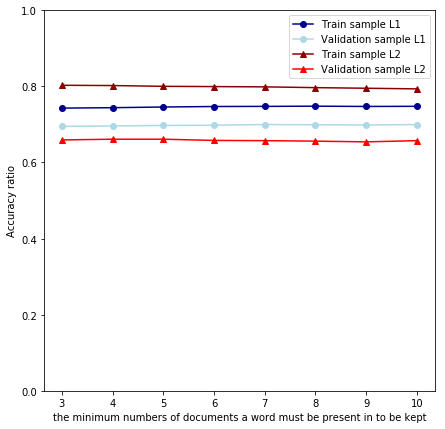

In [29]:
fig = plt.figure(figsize=(7,7))
plt.plot(range(3,11),train_sample_score_l1,'o-',c='darkblue' ,label='Train sample L1')
plt.plot(range(3,11),test_sample_score_l1 ,'o-',c='lightblue',label='Validation sample L1')
plt.plot(range(3,11),train_sample_score_l2,'^-',c='darkred'  ,label='Train sample L2')
plt.plot(range(3,11),test_sample_score_l2 ,'^-',c='red'      ,label='Validation sample L2')
plt.xlabel("the minimum numbers of documents a word must be present in to be kept")
plt.ylabel("Accuracy ratio")
plt.ylim((0.0,1.0))
plt.legend()
plt.show()

Building Model
========

We build model using logistic regression technique with regularization (L1 with regularization parameter equal 2.0). As identifying borough is multiclass problem we use *One vs Rest* algorithm. 

In [30]:
clf = LogisticRegression(random_state=0, multi_class='ovr',penalty='l1', C=2.0)
model = clf.fit(X_train, y_train)

Performance of the model is tested using test sample containing data that was not used in estimation of model or in hyperparameter tuning. 


In [31]:
res = pd.DataFrame()
res['Predict'] = model.predict(X_test) 
res['Actual']  = y_test
 
print(classification_report(res['Predict'], res['Actual']))

                precision    recall  f1-score   support

        bemowo       0.66      0.73      0.69        37
     białołęka       0.84      0.79      0.82        73
       bielany       0.51      0.82      0.63        22
       mokotów       0.84      0.60      0.70       180
        ochota       0.61      0.82      0.70        38
praga południe       0.83      0.83      0.83        69
  praga północ       0.82      0.85      0.84        39
     rembertów       0.00      0.00      0.00         1
      targówek       0.71      0.86      0.77        28
         ursus       0.59      0.83      0.69        12
       ursynów       0.70      0.77      0.73        43
         wawer       0.25      0.50      0.33         6
        wesoła       0.43      0.86      0.57         7
       wilanów       0.65      0.86      0.74        28
          wola       0.78      0.66      0.72        88
        włochy       0.33      0.71      0.45         7
   śródmieście       0.80      0.71      0.75  

Analyzing the diffusion matrix we can conculde that boroughs are usually confused with neighboring districts:
* Śródmieście -> Mokotów, Wola
* Ochota -> Mokotów, Wola, Śródmieście
* Bielany -> Żoliborz
* Wawer -> Białołęka

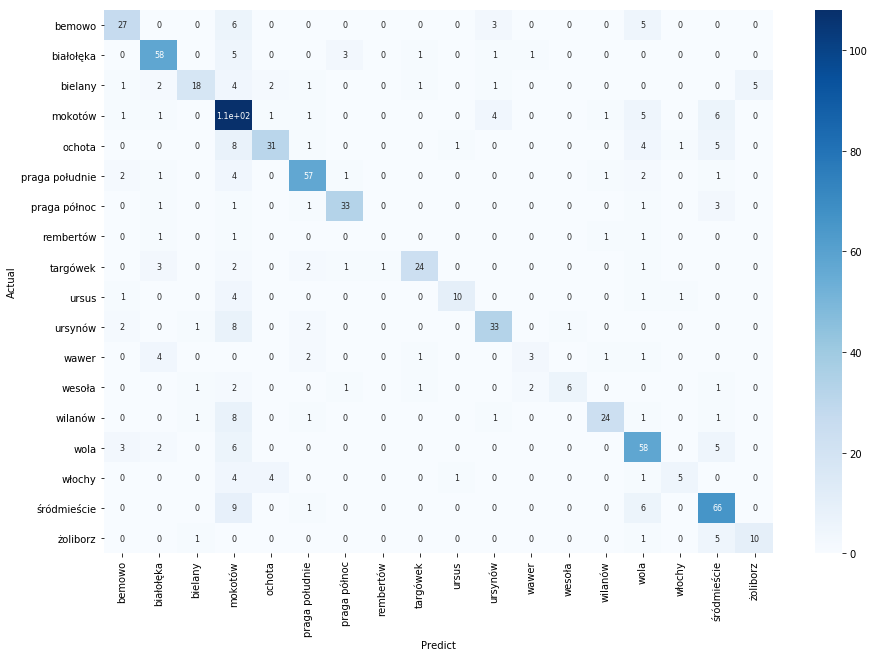

In [32]:
df_confusion = pd.crosstab(res['Actual'],res['Predict'])
plt.figure(figsize = (15,10))
sn.heatmap(df_confusion, annot=True,annot_kws={"size": 8},cmap='Blues')
plt.show()